In [93]:
import pandas as pd
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [94]:
import warnings
warnings.filterwarnings("ignore")

# DATA CLEANING

In [95]:
df.shape

(6362620, 11)

In [96]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [97]:
df = df.drop(['nameOrig','nameDest'],axis='columns')
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [98]:
len(df[df.type=='PAYMENT'])

2151495

In [99]:
len(df[df.type=='PAYMENT'].isFraud==0)

2151495

In [100]:
len(df[df.type=='CASH_IN'])

1399284

In [101]:
len(df[df.type=='CASH_IN'].isFraud==0)

1399284

In [102]:
len(df[df.type=='DEBIT'])

41432

In [103]:
len(df[df.type=='DEBIT'].isFraud==0)

41432

#### As, it can be observed that type column with value PAYMENT have no fraud transaction. Similarly type column with values 'CASH_IN,DEBIT' are transactions that are done where no fraud is made

In [104]:
df[(df['oldbalanceOrg'] < 0) | (df['oldbalanceDest'] < 0)].shape

(0, 9)

### There are no negative balance.
###

In [105]:
dummies = pd.get_dummies(df.type)
df = pd.concat([df,dummies],axis='columns')
# df.isna().sum()

In [106]:
df.drop(['type'],axis='columns',inplace=True)

In [107]:
n_fraud = df[df.isFraud==0]

In [108]:
n_fraud.shape

(6354407, 13)

In [109]:
fraud_df = df[df.isFraud==1]
fraud_df.shape

(8213, 13)

### Huge differnence between both classes makes the dataset imbalanced and the model get biased towards the majority class

In [110]:
types = ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']
target_size=len(fraud_df)
samples=[]
for type in types:
    group = n_fraud[n_fraud[type] == True]
    sampled = group.sample(n=min(target_size,len(group)),random_state=42)
    samples.append(sampled)

In [111]:
n_fraud_new = pd.concat(samples,ignore_index=True)

In [112]:
final_df = pd.concat([n_fraud_new,fraud_df],ignore_index=True)

In [113]:
final_df = final_df.sample(frac=1,random_state = 42).reset_index(drop=True)

In [114]:
final_df.isFraud.value_counts()

isFraud
0    41065
1     8213
Name: count, dtype: int64

In [115]:
final_df.head(3)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,10,277970.88,0.0,0.0,0.00,277970.88,1,0,False,True,False,False,False
1,281,134796.29,11677.0,0.0,51989.06,186785.35,0,0,False,True,False,False,False
2,16,85981.40,294.0,0.0,79550.00,165531.40,0,0,False,True,False,False,False


In [116]:
final_df.shape

(49278, 13)

In [117]:
final_df['errorOrig'] = final_df['newbalanceOrig'] - (final_df['oldbalanceOrg'] - final_df['amount'])
final_df['errorDest'] = final_df['newbalanceDest'] - (final_df['oldbalanceDest'] + final_df['amount'])


### Created two new columns for originated account error and Destination account error which calculates the inconsistency of data in type TRANSFER AND CASH_OUT which is:
### 1. For origin account: ERROR = newBalance - (oldBalance - amount)
### 2. For destination account: ERROR = newBalance - (oldBalance + amount)
###

In [118]:
reset = (final_df['PAYMENT'] == 1) | (final_df['DEBIT'] == 1) | (final_df['CASH_IN'] == 1)
final_df.loc[reset,["errorOrig","errorDest"]] = 0
final_df.sample(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,errorOrig,errorDest
7441,302,20996.55,322248.17,301251.62,0.00,0.00,0,0,False,False,False,True,False,0.00,0.0
33917,12,161150.24,273.00,0.00,347057.48,873110.12,0,0,False,False,False,False,True,160877.24,364902.4


###
## OUTLIER REMOVAL :
### We, capped the amount value exceeding 99 percentile of amount . It is done to: Reduce model distortion
### It also keeps the extreme frauds detectable since we already have error column to detect it.

In [119]:
amount_cap = final_df['amount'].quantile(0.99)
final_df['amount'] = final_df['amount'].clip(upper=amount_cap)
final_df.tail(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,errorOrig,errorDest
49276,310,3660.43,0.0,0.0,0.0,0.00,0,0,False,False,False,True,False,0.00,0.0
49277,380,353272.99,18599.0,0.0,0.0,353272.99,0,0,False,False,False,False,True,334673.99,0.0


### NULL Values

In [120]:
final_df.isnull().sum()

step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
CASH_IN           0
CASH_OUT          0
DEBIT             0
PAYMENT           0
TRANSFER          0
errorOrig         0
errorDest         0
dtype: int64

## To avoid dummy varibale trap and avoid multi-collinearity, we delete CASH_IN column

In [121]:
final_df.drop(['CASH_IN'],axis='columns',inplace=True)

In [122]:
df_to_train = final_df

In [123]:
df_to_train = df_to_train.astype(int)
df_to_train.sample()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER,errorOrig,errorDest
2880,307,39505,0,0,0,0,0,0,0,0,1,0,0,0


### We succesfully created all coloumns with numerical values for model training

##
## IMPLEMENTING GridSearchCV FOR FINDING THE BEST MODEL WITH BEST PARAMETERS

In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

def find_best_model_using_GridSearchCV(X,y):
    algos={
        'Decision Tree': {
            'model':tree.DecisionTreeClassifier(),
            'params':{
                'criterion':['gini','entropy'],
                'splitter':['best','random'],
            }
        },
        'Random Forest': {
            'model':RandomForestClassifier(),
            'params':{
                'n_estimators':[10,15],
                'criterion':['gini','entropy'],
                'max_depth':[10,15]
            }
        },
        'Logistic Regression': {
            'model':LogisticRegression(class_weight="balanced"),
            'params':{
                'C': [0.5,0.7],
                'max_iter':[3,5]
            }
        }
    }
    scores=[]
    cv=StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for algo_name, config in algos.items():
        gs=GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False,verbose=1)
        gs.fit(X,y)
        scores.append({
            'model':algo_name,
            'best_scores':gs.best_score_,
            'best_params':gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','best_scores','best_params'])

In [125]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_to_train.drop(['isFraud','isFlaggedFraud'],axis='columns'),df_to_train.isFraud,test_size=0.2,random_state=42)

In [126]:
len(X_train)

39422

In [127]:
y_train.value_counts()

isFraud
0    32874
1     6548
Name: count, dtype: int64

In [128]:
final_df.isFraud.value_counts()

isFraud
0    41065
1     8213
Name: count, dtype: int64

In [129]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [130]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [131]:
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: isFraud
0    32874
1     6548
Name: count, dtype: int64
After SMOTE: isFraud
0    32874
1    32874
Name: count, dtype: int64


In [132]:
find_best_model_using_GridSearchCV(X_train_res,y_train_res)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,model,best_scores,best_params
0,Decision Tree,0.998662,"{'criterion': 'entropy', 'splitter': 'best'}"
1,Random Forest,0.998783,"{'criterion': 'gini', 'max_depth': 15, 'n_esti..."
2,Logistic Regression,0.892517,"{'C': 0.7, 'max_iter': 5}"


# Hence it can be seen that Random Forest with the given parameters gives the best prediction

In [133]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion = 'gini',max_depth = 15,n_estimators = 15)

In [134]:
model.fit(X_train_res,y_train_res)

RandomForestClassifier(max_depth=15, n_estimators=15)

In [135]:
y_pred = model.predict(X_test_scaled)

Text(95.72222222222221, 0.5, 'Truth')

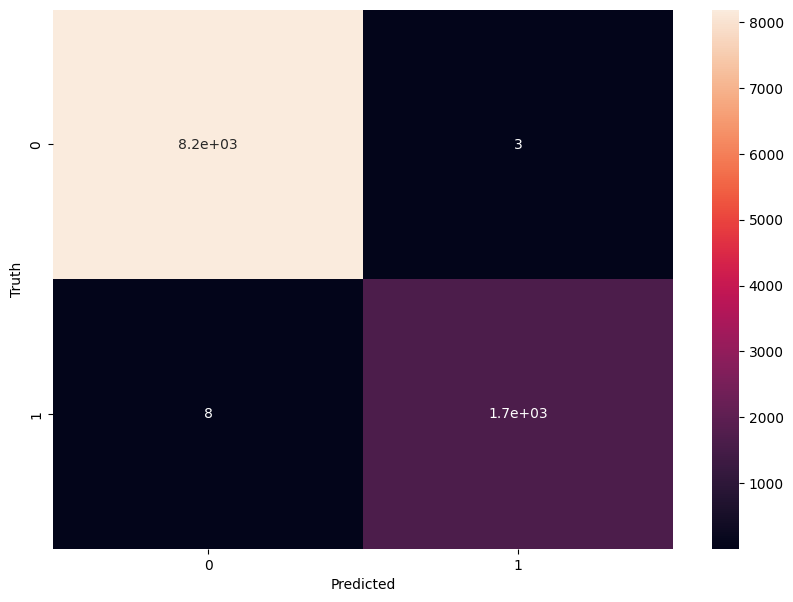

In [136]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
cm = confusion_matrix(y_test,y_pred)
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [137]:
model.score(X_test_scaled,y_test)

0.9988839285714286

<span style="color:purple; background-color:white; font-weight:bold">
    <br><br>
    MODEL STRUCTURE : <br>
    
1. Data preprocessing: StandardScaler applied to numerical features.<br>
2. Balancing classes: Used SMOTE to oversample fraud transactions, as fraud is rare.<br>
3. Model training: Random Forest trained on resampled dataset.<br>
4. Evaluation: Cross-validation + test set predictions to ensure generalization.<br>
</span>

<span style="color:red; background-color:white; font-weight:bold">
    <br><br>
BASED ON DOMAIN KNOWLEDGE AND EDA: <br><br>
1. Transaction amount is critical in determining fraud.<br>
2. Account balances capture the money flows.<br>
3. Transaction type strongly indicated fraud risks.<br>
4. To calculate fraud efficiently, we created errror columns for better training.
</span>

<span style="color:blue; background-color:white; font-weight:bold">
    <br><br>
WHAT ARE THE FACTORS FOR FRAUD DETECTION HOW DOES THE FACTORS MAKES SENSE: <br><br>
The factors are Transaction_type, Amount and Balance differneces. <br>
1. Fraudsters typically transfers money to different account(TRANSFER) or withdraw cash quickly(CASH_OUT).<br>
2. Amounts are usally large when fraud.<br>
3. Imbalances indicate how the account balances are not updated and stronly are fraud signals.<br>
</span>

<span style="color:green; background-color:white; font-weight:bold">
    <br><br>
PREVENTION TO BE ADOPTED TO REDUCE FRAUD RISK: <br><br>
1. Deploying the trained model to every live transaction<br>
2. Flag large transaction and verify.<br>
3. Building behavior-based-model to alert when transactions deviates from client's normal pattern<br>
</span>

<span style="color:orange; background-color:white; font-weight:bold">
<br><br>
DETERMINING IT'S ACCURACY: <br><br>
1. Using classification report and metrics like Recall, Precision etc<br>
2. Retraining model regularly.<br>
</span>

# DoNe !